In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt 

In [2]:
def trans_importer(start =1, to =1):
    merged = pd.DataFrame()
    for i in range(start,to+1):
        name = "transaction" + str(i) + ".csv" 
        dummy_df = pd.read_csv(name).drop("Unnamed: 0",axis =1)
        merged = pd.concat([merged, dummy_df], ignore_index=True)
    return merged

def article_id_parser(df):
    df = df.dropna(how='all')
    df = df.dropna(subset=['article_id'])
    return df

# Import  data

In [3]:
articles = pd.read_csv('articles.csv')
customers = pd.read_csv('customers.csv')
# we have too large transcation data, so I had to split them up into 10 CSVs, still each over 3milions rows 
trans = trans_importer(1,10)

# Parse data

In [4]:
# parse the transaction data
trans = article_id_parser(trans)
trans

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


# Naive Approach: Item Clustering
This will group the aricle_ids for each customer, which gives a list of item sold for each customer
 - counted_trans : merged transaction data for each customer

In [5]:
# merge articles for each customer
def merger(df,k = "customer_id",v = "article_id"):
    df = df.loc[:,[k,v]]
    keys, values = df.sort_values(k).values.T # unpack the keys(customer_id) and values(artical_id)
    ukeys, index = np.unique(keys, return_index = True) # get the index map for each key
    arrays = np.split(values, index[1:]) # cut it by index
    merged = pd.DataFrame({k:ukeys, v:[list(i) for i in arrays]}) # merge as data frame
    return merged

In [6]:
merged_trans = merger(trans)
merged_trans # good news is that it has ben shrunken down from 9536496 to 814985 rows!!

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[745232001, 890498002, 887593002, 841260003, 6..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[739590027, 673677002, 800436010, 778064010, 7..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[858883002, 750424014, 750424014, 870304002, 8..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[742079001, 732413001]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[818320001, 399061015, 827971001, 589440005, 6..."
...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[711940003, 253448003, 557599022, 712924008, 8..."
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[783333003, 663568009, 765517001, 699623004, 7..."
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,"[597918001, 592986010, 592986002, 781613006, 6..."
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,"[840360003, 866755002, 714790020, 806241002, 8..."


# Division by age group
divided into 4 groups by 10 (min: 16.0, max: 99.0)

In [7]:
def age_group_creater(df):
    age_groups = [10.0,20.0,30.0,40.0,float(max(df['age']))]
    customer_age_list = list()
    for i in tqdm(range(len(age_groups)-1)):
        condition = np.logical_and(df.age >=age_groups[i], df.age < age_groups[i+1])
        # customer_age_dict[("customer" + str((i+1)*10))] = df[condition]
        customer_age_list.append(df[condition])
    return customer_age_list

In [8]:
age_list = age_group_creater(customers)
age_list[1] # 20 ages data

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.76it/s]


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...
1371973,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,1.0,1.0,ACTIVE,Regularly,22.0,e89f7536a3d1ff494b6324604db93646fca956d85f8e83...
1371974,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,1.0,1.0,ACTIVE,Regularly,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...


In [9]:
tw = age_list[1] # 20 ages data
tw.to_csv("age20.csv",index = False)

In [10]:
age_list[1]["postal_code"].apply(lambda x : len(x)) # 20 ages data

1          64
2          64
6          64
8          64
9          64
           ..
1371973    64
1371974    64
1371975    64
1371976    64
1371977    64
Name: postal_code, Length: 528358, dtype: int64

In [11]:
trans[1:400]

,t_dat,customer_id,article_id,price,sales_channel_id
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
...,...,...,...,...,...
395,2018-09-20,0218014619321c250395c5cb9bc9f5323745113f61f3a1...,675281001,0.025407,2
396,2018-09-20,0218014619321c250395c5cb9bc9f5323745113f61f3a1...,663368001,0.050831,2
397,2018-09-20,0218e0970319a0f68ebb78a6cdfffb8ddc461d0d02eeb8...,649057002,0.033881,2
398,2018-09-20,021bfdd3e66576efce4fdffc66c8e7837abad6ac50c10d...,685687001,0.016932,2


In [12]:
unique_postals = np.unique(customers["postal_code"])
len(unique_postals)

352899

# remove redundancy in postal codes

In [13]:
352899/len(customers)

0.25721876412192596

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='club_member_status'>

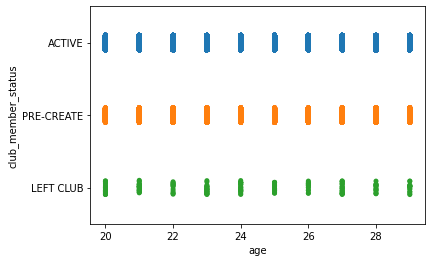

In [14]:
sns.stripplot(tw["age"],tw["club_member_status"],dodge=True)

# Draw top 50 sellers for each age group
 - top50_dict : Dictionary that contains top 50 sellers for each age group
   keys : "age10", "age20", "age30", "age40"
   

In [15]:
def top50_creater(df):
    target_id = df["customer_id"]
    filterd_trans = merged_trans[merged_trans["customer_id"].isin(target_id)]
    article_list = [article for articles in filterd_trans["article_id"] for article in articles]
    article_list = np.unique(article_list,return_counts = True)
    article_list = np.transpose(article_list)
    article_counts = pd.DataFrame(article_list, columns = ['article_id', 'counts'])
    article_counts = article_counts.sort_values(by=["counts"], ascending=False)
    top50 = article_counts[0:99]['article_id']
    return list(top50)

def top50_dictionary(df):
    top50_dict = dict()

    for i,age_group in enumerate(df):
        key = "age"+str((i+1)*10)
        top50_dict[key] = top50_creater(age_group)
    return top50_dict

In [16]:
top50_dict = top50_dictionary(age_list)

In [17]:
top50_dict

{'age10': [706016001,
  759871002,
  706016002,
  464297007,
  759871001,
  372860002,
  673396002,
  720125001,
  733749001,
  759465001,
  448509014,
  372860001,
  685814003,
  706016003,
  684209004,
  688537004,
  706016006,
  684209013,
  706016015,
  741356002,
  748355003,
  351484002,
  688537011,
  723469001,
  685814001,
  759871025,
  715624001,
  599580052,
  599580017,
  673677002,
  399256001,
  610776002,
  599580055,
  759871004,
  399223001,
  554479001,
  684209027,
  736530007,
  599580038,
  590928001,
  636323001,
  624486001,
  759871003,
  772902001,
  621381001,
  715624010,
  568601006,
  554479005,
  699080001,
  739590032,
  621381012,
  806388003,
  824337001,
  408875001,
  806388001,
  806388002,
  610776001,
  562245046,
  688537021,
  640021011,
  507909001,
  759871013,
  759469001,
  448509001,
  751471001,
  723529001,
  816423004,
  559630026,
  639448001,
  803468002,
  600886001,
  795440001,
  759482001,
  539723005,
  516859008,
  685814033,
  5

In [18]:
top50_dict["age20"] # black pants, another black pants black stockings for age group 20

[706016001,
 706016002,
 372860001,
 759871002,
 156231001,
 464297007,
 610776002,
 448509014,
 399223001,
 706016003,
 372860002,
 720125001,
 673396002,
 610776001,
 351484002,
 688537004,
 562245046,
 158340001,
 590928001,
 673677002,
 562245001,
 111586001,
 751471001,
 706016015,
 111593001,
 741356002,
 484398001,
 759871001,
 684209004,
 399256001,
 160442007,
 228257001,
 568601006,
 554450001,
 599580017,
 685814001,
 706016006,
 717490008,
 448509001,
 688537011,
 573716012,
 806388002,
 507909001,
 749699002,
 806388001,
 608776002,
 636323001,
 684209013,
 689109001,
 685816002,
 600886001,
 733749001,
 711053003,
 806388003,
 624486001,
 539723005,
 579302001,
 749699001,
 759465001,
 436261001,
 611415001,
 736530007,
 689109003,
 685816001,
 537116001,
 692930001,
 160442010,
 723469001,
 695632002,
 683662005,
 108775015,
 618800001,
 599580055,
 562245018,
 685814003,
 772902001,
 730683001,
 719655001,
 699080001,
 564786001,
 539723001,
 565379001,
 715624001,
 692

# article_id dimension shrinkage

In [19]:
reduced_article_trans = pd.merge(trans, articles[["article_id", "product_code", "product_type_no"]], on="article_id")
reduced_article_trans

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,product_type_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,283
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,663713,283
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,663713001,0.050831,2,663713,283
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,663713001,0.050831,1,663713,283
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,663713001,0.050831,2,663713,283
...,...,...,...,...,...,...,...
31788319,2020-09-22,ec794d6268ee3c75b5bbea014e3299d994bcd1180ecf6d...,860135008,0.038119,1,860135,259
31788320,2020-09-22,ec794d6268ee3c75b5bbea014e3299d994bcd1180ecf6d...,539060028,0.016017,1,539060,308
31788321,2020-09-22,ec794d6268ee3c75b5bbea014e3299d994bcd1180ecf6d...,539060028,0.016000,1,539060,308
31788322,2020-09-22,ee9c048de16034be4aa95c91adce7f7bda442e6528406e...,810737015,0.033881,2,810737,49


In [20]:
reduced_article_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,product_type_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,283
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,663713,283
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,663713001,0.050831,2,663713,283
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,663713001,0.050831,1,663713,283
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,663713001,0.050831,2,663713,283


In [21]:
print("article id: ",len(reduced_article_trans.article_id.unique()),"Prod Code: ",len(reduced_article_trans.product_code.unique()),"Product type: ",len(reduced_article_trans.product_type_no.unique()))

article id:  104547 Prod Code:  46834 Product type:  131


In [22]:
reduced_article_trans.to_csv("reduced_article_trans.csv", index = False)

In [23]:
pt_sliced = reduced_article_trans.loc[:,["customer_id","product_type_no"]]
compact_pt = merger(pt_sliced,"customer_id","product_type_no")

# merge the traning data

In [24]:
customers_postal = customers.loc[:,["customer_id","postal_code"]]
customers_postal

,customer_id,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [25]:
pt_sliced = reduced_article_trans.loc[:,["customer_id","product_type_no"]]

In [26]:
postal_pt_trans = pt_sliced.merge(customers_postal,on="customer_id",how = "left")
postal_pt_trans = postal_pt_trans.loc[:,["product_type_no","postal_code"]]

In [27]:
compact_postal_pt_trans = merger(postal_pt_trans ,"postal_code","product_type_no")
compact_postal_pt_trans

,postal_code,product_type_no
0,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,"[272, 254, 252, 253, 306, 272, 78, 81, 78, 254..."
1,00005652fb5323679a5d608ce8c94fbb57bc15d3d8c01a...,"[144, 272, 144, 265, 275, 272, 273, 274, 57, 5..."
2,0000eda740da878fb9df474806be9597f043eb5f748091...,"[273, 272, 272, 255, 255, 252, 255, 252, 252, ..."
3,0001617618d0facf2ae73cdba7b8caefb3c05e6987a98a...,"[308, 70, 263, 265]"
4,00016f13cb796865b053cda4d470b4a3146553eaa36241...,"[306, 286, 286, 253, 306, 306, 256, 272, 306, ..."
...,...,...
352331,ffffcc2ddf5fbe05ea3e2bdb5f920237c5167862fa906a...,"[255, 265, 272, 286, 255, 273, 265, 254, 254, ..."
352332,ffffd89fe6a23128efcee162ad22b229e0c7e3d9bba5a3...,"[272, 265, 298, 59, 273, 265, 275, 258, 265, 2..."
352333,ffffdad63acd760f392e724af1e8fe05984ebef3749ede...,"[255, 255, 286, 273, 265, 286, 302, 304, 255, ..."
352334,ffffdb8046b028cc705ae0b3bc0267ac7f2a44cd1e4b0b...,"[298, 265, 298, 306, 298, 59, 298, 274, 298, 5..."


In [28]:
compact_postal_pt_trans

,postal_code,product_type_no
0,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,"[272, 254, 252, 253, 306, 272, 78, 81, 78, 254..."
1,00005652fb5323679a5d608ce8c94fbb57bc15d3d8c01a...,"[144, 272, 144, 265, 275, 272, 273, 274, 57, 5..."
2,0000eda740da878fb9df474806be9597f043eb5f748091...,"[273, 272, 272, 255, 255, 252, 255, 252, 252, ..."
3,0001617618d0facf2ae73cdba7b8caefb3c05e6987a98a...,"[308, 70, 263, 265]"
4,00016f13cb796865b053cda4d470b4a3146553eaa36241...,"[306, 286, 286, 253, 306, 306, 256, 272, 306, ..."
...,...,...
352331,ffffcc2ddf5fbe05ea3e2bdb5f920237c5167862fa906a...,"[255, 265, 272, 286, 255, 273, 265, 254, 254, ..."
352332,ffffd89fe6a23128efcee162ad22b229e0c7e3d9bba5a3...,"[272, 265, 298, 59, 273, 265, 275, 258, 265, 2..."
352333,ffffdad63acd760f392e724af1e8fe05984ebef3749ede...,"[255, 255, 286, 273, 265, 286, 302, 304, 255, ..."
352334,ffffdb8046b028cc705ae0b3bc0267ac7f2a44cd1e4b0b...,"[298, 265, 298, 306, 298, 59, 298, 274, 298, 5..."


In [29]:
pt_hash_keys=sorted(list(articles["product_type_no"].unique()))
hash_map = {i:0 for i in pt_hash_keys}

In [30]:
hash_map.copy()

{-1: 0,
 49: 0,
 57: 0,
 59: 0,
 60: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 98: 0,
 100: 0,
 102: 0,
 144: 0,
 155: 0,
 156: 0,
 161: 0,
 196: 0,
 230: 0,
 231: 0,
 245: 0,
 252: 0,
 253: 0,
 254: 0,
 255: 0,
 256: 0,
 257: 0,
 258: 0,
 259: 0,
 260: 0,
 261: 0,
 262: 0,
 263: 0,
 264: 0,
 265: 0,
 267: 0,
 268: 0,
 270: 0,
 271: 0,
 272: 0,
 273: 0,
 274: 0,
 275: 0,
 276: 0,
 277: 0,
 283: 0,
 284: 0,
 285: 0,
 286: 0,
 287: 0,
 288: 0,
 289: 0,
 291: 0,
 293: 0,
 295: 0,
 296: 0,
 297: 0,
 298: 0,
 299: 0,
 300: 0,
 302: 0,
 303: 0,
 304: 0,
 305: 0,
 306: 0,
 307: 0,
 308: 0,
 326: 0,
 349: 0,
 351: 0,
 366: 0,
 389: 0,
 464: 0,
 465: 0,
 467: 0,
 468: 0,
 470: 0,
 475: 0,
 476: 0,
 477: 0,
 483: 0,
 489: 0,
 491: 0,
 492: 0,
 493: 0,
 494: 0,
 495: 0,
 496: 0,
 498: 0,
 4

# Isomorphism

In [31]:
def isomorpher(hash_map,df):
    pts_series = df["product_type_no"]
    vector_list = [np.nan]*len(df)
    for i,pts in tqdm(enumerate(pts_series)):
        temp = hash_map.copy()
        for pt in pts:
            temp[pt] += 1
        vector_list[i] = list(temp.values())
    return vector_list

In [32]:
vectors = isomorpher(hash_map,compact_postal_pt_trans)

352336it [00:12, 29147.88it/s]


In [33]:
compact_postal_pt_trans["vector"] = vectors


AttributeError: 'str' object has no attribute 'csv'

In [36]:
compact_postal_pt_trans.to_csv("compact_postal_pt_trans.csv",index = False)

# Hierarchical

In [ ]:
from math import floor

In [ ]:
subset = vectors[0:floor(len(vectors)*0.1)]

In [ ]:
from sklearn.cluster import AgglomerativeClustering

data = np.array(subset)

#cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
#cluster.fit_predict(data)